In [4]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from fct.objectives import PeriodicExample2D, WindowedLeastSquares
from lib.utils import consistent_polytope_nd
from lib.tracking_analysis import bisection_thm1, bisection_thm2
from fct.algorithms import GradientDescent, Nesterov, TMM, Algorithm
from lib.algorithms_unconstrained import gradient_descent, nesterov, triple_momentum

In [15]:
# Plot settings
plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'serif',
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'legend.fontsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10
})

In [2]:
def calculate_L_bounds(objective, n_points=1000):
    """
    Calculate L_max, L_min, delta_L_max and delta_m_max for a given function

    Parameters:
    - objective: An instance of a function class (e.g., PeriodicExample2D, WindowedLeastSquares)
    - n_points: Number of points to sample in the domain for estimating bounds

    Returns:
    - L_min: Minimum Lipschitz constant
    - L_max: Maximum Lipschitz constant
    - delta_L_max: Maximum change in Lipschitz constant between consecutive points
    - delta_m_max: Maximum change in strong convexity constant between consecutive points
    """
    L_max, L_min, delta_L_max, delta_m_max
    t = 200
    for k in range(t+1):
        objective.update(k)


    # Sample points in the domain
    x_samples = np.random.uniform(low=[-100]*objective.nx, high=[100]*objective.nx, size=(n_points, objective.nx))
    print(f"x_samples shape: {x_samples.shape}")
    print(f"x_samples: {x_samples}")

    # Evaluate gradients and Hessians at sampled points
    gradients = np.array([objective.gradient(x) for x in x_samples])
    hessians = np.array([objective.hessian(x) for x in x_samples])

    # Compute eigenvalues of Hessians to estimate m and L
    eigenvalues = np.array([np.linalg.eigvalsh(hess) for hess in hessians])
    m_values = np.min(eigenvalues, axis=1)
    L_values = np.max(eigenvalues, axis=1)

    # Calculate L_min, L_max, delta_L_max, delta_m_max
    L_min = np.min(L_values)
    L_max = np.max(L_values)
    delta_L = np.abs(np.diff(L_values))
    delta_m = np.abs(np.diff(m_values))

    delta_L_max = np.max(delta_L) if len(delta_L) > 0 else 0
    delta_m_max = np.max(delta_m) if len(delta_m) > 0 else 0

    return L_min, L_max, delta_L_max, delta_m_max

def calculate_consistent_polytope(objective, n_points=1000):
    """
    Calculate the consistent polytope for the given objective function.

    Parameters:
    - objective: An instance of a function class (e.g., PeriodicExample2D, WindowedLeastSquares)
    - n_points: Number of points to sample in the domain for estimating the polytope

    Returns:
    - consistent_polytope: A list of tuples representing the consistent polytope
    """
    # Sample points in the domain
    x_samples = np.random.uniform(low=[-100]*objective.nx, high=[100]*objective.nx, size=(n_points, objective.nx))

    # Evaluate gradients at sampled points
    gradients = np.array([objective.gradient(x) for x in x_samples])

    # Compute the consistent polytope using the sampled gradients
    consistent_polytope = consistent_polytope_nd(gradients)

    return consistent_polytope

def compute_algorithm_parameters(algo_name, m, L, consistent_polytope):
    """
    Compute algorithm parameters using bisection methods for the given algorithm.

    Parameters:
    - algo_name: Name of the algorithm ('gradient_descent', 'nesterov', 'tmm')
    - m: Strong convexity constant
    - L: Lipschitz constant
    - consistent_polytope: A list of tuples representing the consistent polytope

    Returns:
    - algorithm: An instance of the algorithm class with updated parameters
    """
    # Select the appropriate algorithm class
    if algo_name == 'gradient_descent':
        algorithm = GradientDescent(m=m, L=L, nx=1, delta_model=False)
        algo = gradient_descent
    elif algo_name == 'nesterov':
        algorithm = Nesterov(m=m, L=L, nx=1, delta_model=False)
        algo = nesterov
    elif algo_name == 'tmm':
        algorithm = TMM(m=m, L=L, nx=1, delta_model=False)
        algo = triple_momentum
    else:
        raise ValueError("Unsupported algorithm name. Choose from 'gradient_descent', 'nesterov', or 'tmm'.")

    # Compute parameters for sector IQC
    rho_sec, sol_sec = bisection_thm1(algo=algo, consistent_polytope=consistent_polytope)
    algorithm.rho_sec = rho_sec
    algorithm.c_sec = sol_sec[0]
    algorithm.lambd = sol_sec[1]

    # Compute parameters for off-by-1 IQC
    rho, sol = bisection_thm2(algo=algo, consistent_polytope=consistent_polytope, optimize_bound=True)
    algorithm.rho = rho
    algorithm.c1, algorithm.c2 = sol[0]
    algorithm.lambd = sol[1]
    algorithm.gamma_xi = sol[2]
    algorithm.gamma_delta = sol[3]

    return algorithm

In [ ]:
# Define the objective function
objective = PeriodicExample2D(omega=0.1)

# Calculate L bounds
# L_min, L_max, delta_L_max, delta_m_max = calculate_L_bounds(objective)
# print(f"L_min: {L_min}, L_max: {L_max}, delta_L_max: {delta_L_max}, delta_m_max: {delta_m_max}")

L_range = np.logspace(np.log10(1/0.8 + 1e-3), 2, 10)
m_range = L_range * 0.4
rhos_ogd, rhos_nest, rhos_tmm = [], [], []
# L = 10
# m = 10
n_grid = 2
for L, m in tqdm(zip(L_range, m_range), total=len(L_range)):
    L_min, L_max = L * 0.8, L
    m_min, m_max = m * 0.4, m
    grid_step = (L_max - L_min) / n_grid

    params = np.array([np.linspace(L_min, L_max, n_grid + 1),
                np.linspace(m_min, m_max, n_grid + 1)])
    # print(f"Parameter grid: {params}")
    # delta_L_max = lambda rate_bound: rate_bound * (L_max - L_min)
    # delta_m_max = lambda rate_bound: rate_bound * (m_max - m_min)

    grid_points = consistent_polytope_nd(params, np.array([-delta_L_max(rate_bound=0.05),-delta_m_max(rate_bound=0.05)]), np.array([-delta_L_max(rate_bound=0.05),-delta_m_max(rate_bound=0.05)]), step_size=grid_step)
    # print(f"Grid points: {grid_points}")
    rho, sol = bisection_thm2(algo=gradient_descent, consistent_polytope=grid_points, optimize_bound=True)
    rhos_ogd.append((rho, sol))

    rho, sol = bisection_thm2(algo=nesterov, consistent_polytope=grid_points, optimize_bound=True)
    rhos_nest.append((rho, sol))

    rho, sol = bisection_thm2(algo=triple_momentum, consistent_polytope=grid_points, optimize_bound=True)
    rhos_tmm.append((rho, sol))

    # Calculate consistent polytope
    # consistent_polytope = calculate_consistent_polytope(objective)
    # print(f"Consistent Polytope: {consistent_polytope}")

    # Compute algorithm parameters for Nesterov's method
    # algorithm = compute_algorithm_parameters('nesterov', m=1, L=L_max, consistent_polytope=consistent_polytope)
    # print(f"Algorithm Parameters - rho: {algorithm.rho}, c1: {algorithm.c1}, c2: {algorithm.c2}, lambda: {algorithm.lambd}, gamma_xi: {algorithm.gamma_xi}, gamma_delta: {algorithm.gamma_delta}")

  0%|          | 0/10 [00:00<?, ?it/s]

/home/hadi/bwSyncShare/2025_Hadi_Elnemr/02_Implementations/.env/lib/python3.10/site-packages/mosek/__init__.py:18617: UserWarning: Argument sub in putvarboundlist: Incorrect array format causing data to be copied
  warnings.warn("Argument sub in putvarboundlist: Incorrect array format causing data to be copied");
/home/hadi/bwSyncShare/2025_Hadi_Elnemr/02_Implementations/.env/lib/python3.10/site-packages/mosek/__init__.py:18925: UserWarning: Argument subj in putclist: Incorrect array format causing data to be copied
  warnings.warn("Argument subj in putclist: Incorrect array format causing data to be copied");
/home/hadi/bwSyncShare/2025_Hadi_Elnemr/02_Implementations/.env/lib/python3.10/site-packages/mosek/__init__.py:18349: UserWarning: Argument sub in putconboundlist: Incorrect array format causing data to be copied
  warnings.warn("Argument sub in putconboundlist: Incorrect array format causing data to be copied");
100%|██████████| 10/10 [01:50<00:00, 11.04s/it]


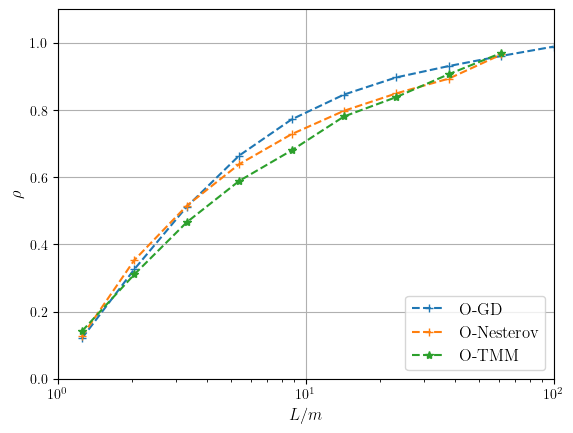

In [ ]:
### Extract quantities to plot
rhos_ogd_, rhos_nest_, rhos_tmm_ = map(lambda x: np.array([rho for rho, _ in x]), [rhos_ogd, rhos_nest, rhos_tmm])
tableau10 = plt.get_cmap('tab10').colors

### Plot results
plt.semilogx(
plt.xlabel(r'$L/m$')
plt.ylabel(r'$\rho$')

plt.xlim([1,100])
plt.ylim([0,1.1])

plt.legend(loc='lower right')
plt.grid()
plt.show()


In [ ]:
# Calc

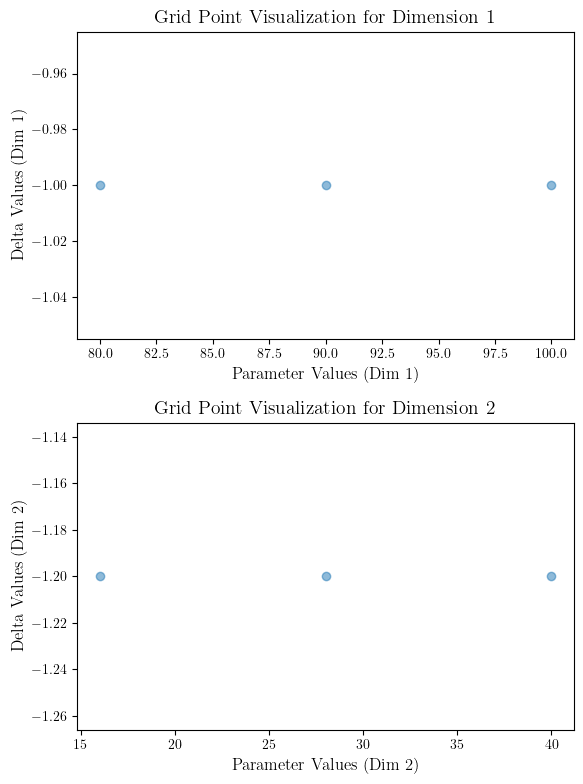

In [ ]:
def visualize(grid_points, param_dim: int = None):
        """
        Visualizes the grid points in scatter plots.
        """

        p_values = np.array([p_k for p_k, _ in grid_points])
        delta_values = np.array([delta_p for _, delta_p in grid_points])
        num_dims = p_values.shape[1]  # Number of dimensions

        if param_dim is not None:
            if param_dim >= num_dims or param_dim < 0:
                print(f"Invalid dimension for visualization: {param_dim}")
                return

            # Single dimension plot
            plt.figure(figsize=(6, 4))
            plt.scatter(p_values[:, param_dim], delta_values[:, param_dim], alpha=0.5, label=f"Delta Values (Dim {param_dim+1})")
            plt.xlabel(f"Parameter Values (Dim {param_dim+1})")
            plt.ylabel(f"Delta Values (Dim {param_dim+1})")
            plt.title(f"Grid Point Visualization for Dimension {param_dim+1}")
            plt.show()
        else:
            # Multiple subplots for all dimensions
            fig, axes = plt.subplots(num_dims, 1, figsize=(6, 4 * num_dims))
            if num_dims == 1:
                axes = [axes]  # Ensure axes is always iterable

            for dim in range(num_dims):
                ax = axes[dim]
                ax.scatter(p_values[:, dim], delta_values[:, dim], alpha=0.5, label=f"Dim {dim}")
                ax.set_xlabel(f"Parameter Values (Dim {dim+1})")
                ax.set_ylabel(f"Delta Values (Dim {dim+1})")
                ax.set_title(f"Grid Point Visualization for Dimension {dim+1}")

            plt.tight_layout()
            plt.show()
visualize(grid_points=grid_points)